In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ufo-sights-2016-us-and-canada/UFOs_coord.csv
/kaggle/input/ufo-sights-2016-us-and-canada/UFOs_coord.xlsx
/kaggle/input/world-countries/world-countries.json


# Importing Packages

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
from wordcloud import WordCloud
import plotly.express as px

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Data Overview

In [3]:
df = pd.read_excel('/kaggle/input/ufo-sights-2016-us-and-canada/UFOs_coord.xlsx')
df.head()

Date / Time Country        City State    Shape  \
0  12/21/16 19:15     USA  Waynesboro    VA   Sphere   
1  12/21/16 00:00     USA  Louisville    KY  Unknown   
2  12/20/16 22:30     USA  Santa Rosa    CA   Sphere   
3  12/20/16 19:00     USA      Fresno    CA   Circle   
4  12/19/16 21:53     USA     Reymert    AZ   Circle   

                                             Summary        lat         lng  
0               Bright round object hovering in sky.  38.065229  -78.905888  
1  Multiple craft ascending from north of Shelbyv...  38.254238  -85.759407  
2  Bright orange planet-like object sighted near ...  38.440467 -122.714431  
3      Twelve orange globes in formation over Fresno  36.729529 -119.708861  
4  While camping in the Cottonwood canyon Rd., al...  33.229779 -111.209290

In [4]:
df.rename(columns={'Date / Time': 'Date/Time', 'Shape': 'Shape of the UFO'}, inplace=True)

# Common Words

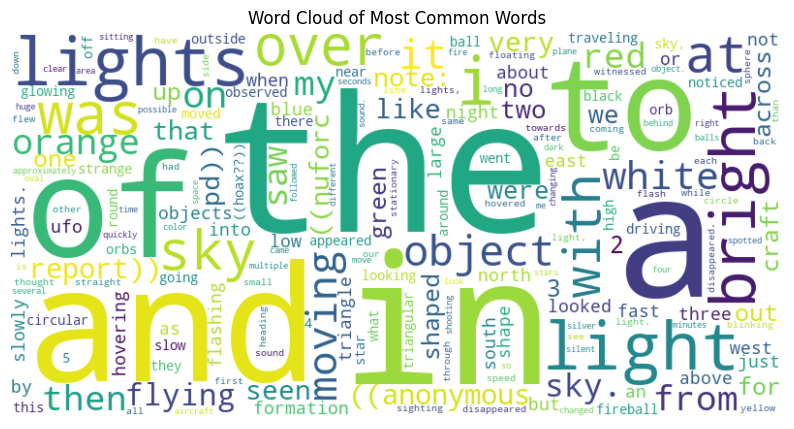

In [5]:
text = ' '.join(df['Summary'].dropna().values.tolist())
word_frequencies = text.lower().split()
word_counts = {}
for word in word_frequencies:
    if word not in word_counts:
        word_counts[word] = 0
    word_counts[word] += 1
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Common Words')
plt.show()

# Map where UFO spotted

In [6]:
fig = px.scatter_mapbox(df, lat='lat', lon='lng', hover_data=['Summary'], zoom=3)
fig.update_layout(mapbox_style='open-street-map')
fig.update_layout(title='Sightings')
fig.show()

# Frequently Mentioned Keywords

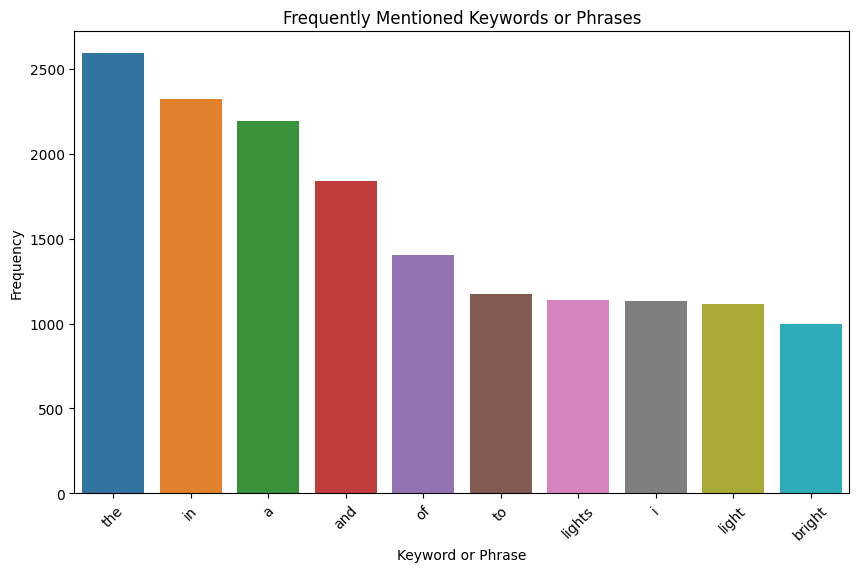

In [7]:
text = ' '.join(df['Summary'].dropna().values.tolist())
word_frequencies = text.lower().split()
word_counts = {}
for word in word_frequencies:
    if word not in word_counts:
        word_counts[word] = 0
    word_counts[word] += 1
N = 10  
top_keywords = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:N]
plt.figure(figsize=(10, 6))
sns.barplot(x=[keyword for keyword, _ in top_keywords], y=[count for _, count in top_keywords])
plt.title('Frequently Mentioned Keywords or Phrases')
plt.xlabel('Keyword or Phrase')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Numerical Eda

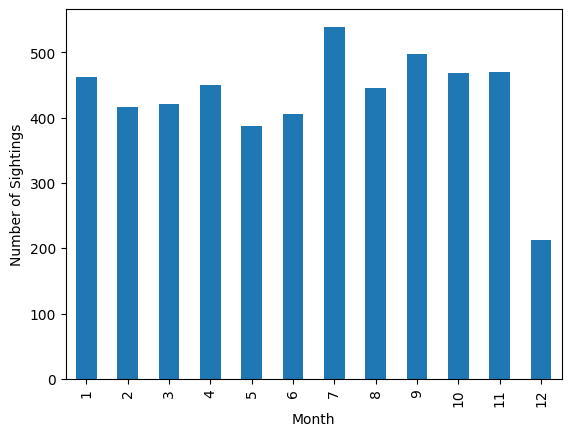

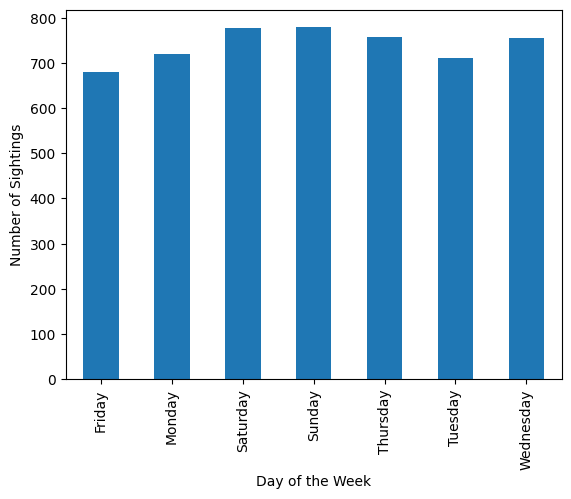

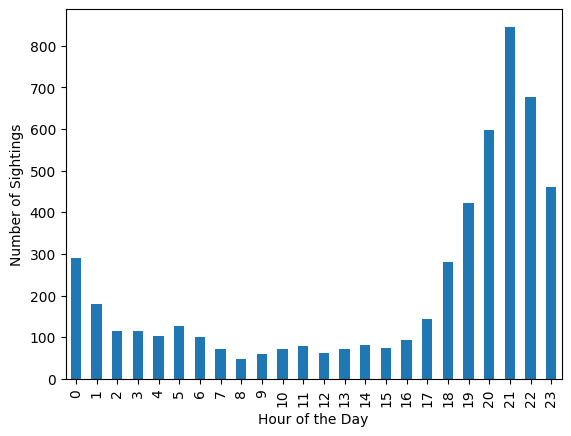

In [8]:
df['Date/Time'] = pd.to_datetime(df['Date/Time'])
df['Month'] = df['Date/Time'].dt.month
df['DayOfWeek'] = df['Date/Time'].dt.day_name()
df['HourOfDay'] = df['Date/Time'].dt.hour
monthly_counts = df['Month'].value_counts().sort_index()
monthly_counts.plot(kind='bar', xlabel='Month', ylabel='Number of Sightings')
plt.show()

day_counts = df['DayOfWeek'].value_counts().sort_index()
day_counts.plot(kind='bar', xlabel='Day of the Week', ylabel='Number of Sightings')
plt.show()
hourly_counts = df['HourOfDay'].value_counts().sort_index()
hourly_counts.plot(kind='bar', xlabel='Hour of the Day', ylabel='Number of Sightings')
plt.show()

# Distribution of UFO Shapes

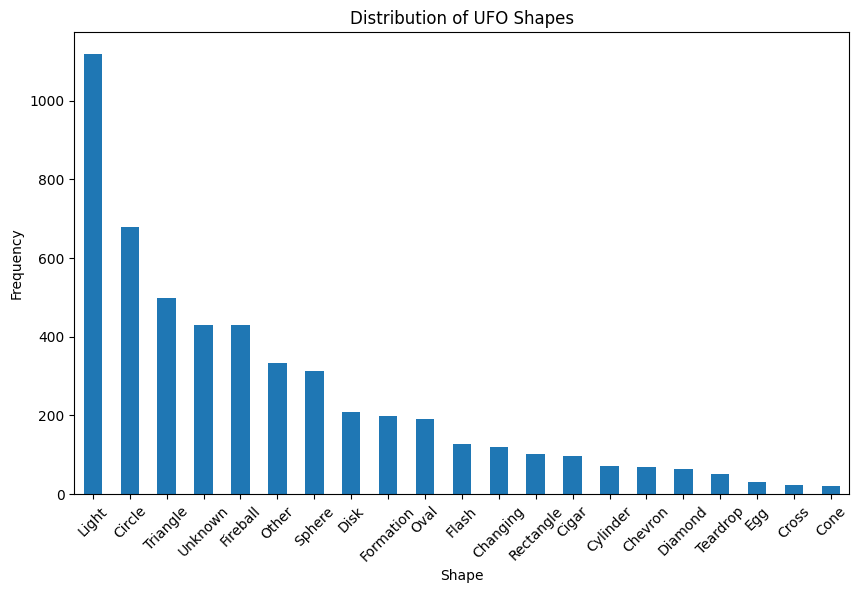

In [9]:
shape_counts = df['Shape of the UFO'].value_counts()
plt.figure(figsize=(10, 6))
shape_counts.plot(kind='bar')
plt.title('Distribution of UFO Shapes')
plt.xlabel('Shape')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Distribution of UFO Shapes by Region

<Figure size 2000x600 with 0 Axes>

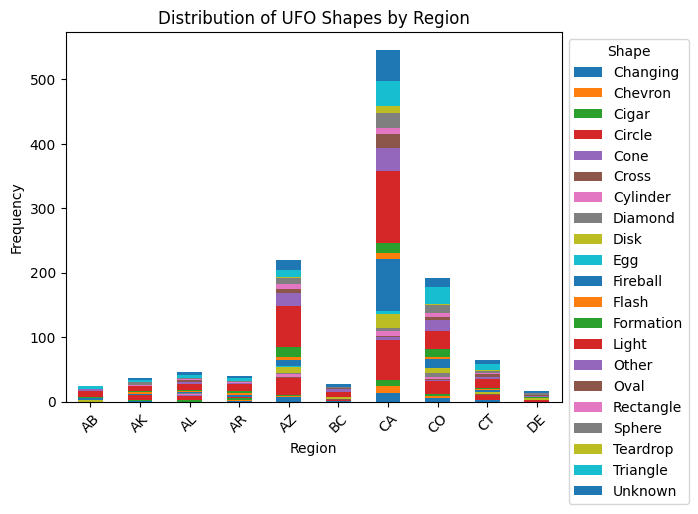

In [10]:
shape_counts_by_region = df.groupby(['State', 'Shape of the UFO']).size().unstack()
shape_counts_by_region = shape_counts_by_region.head(10)
plt.figure(figsize=(20, 6))
shape_counts_by_region.plot(kind='bar', stacked=True)
plt.title('Distribution of UFO Shapes by Region')
plt.xlabel('Region')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend(title='Shape', bbox_to_anchor=(1, 1))
plt.show()

# Text Analysis

In [11]:
stop_words = set(stopwords.words('english'))
reports_summary = df['Summary'].str.lower()
tokens = []
for summary in reports_summary:
    summary_tokens = word_tokenize(summary)
    summary_tokens = [token for token in summary_tokens if token.isalnum() and token not in stop_words]
    tokens.extend(summary_tokens)
keyword_counts = Counter(tokens)
top_keywords = keyword_counts.most_common(10)

keyword = 'light' 
sighting_details = df[df['Summary'].str.contains(keyword)]['Summary'].tolist()

analyzer = SentimentIntensityAnalyzer()
sentiments = [analyzer.polarity_scores(summary)['compound'] for summary in reports_summary]
average_sentiment = sum(sentiments) / len(sentiments)

print('Frequently mentioned keywords or phrases:')
for keyword, count in top_keywords:
    print(f'{keyword}: {count}')
print('\nSighting details containing the keyword:', keyword)
for detail in sighting_details:
    print(detail)
print('\nAverage sentiment:', average_sentiment)

Frequently mentioned keywords or phrases:
lights: 1405
sky: 1368
light: 1316
bright: 1055
object: 772
moving: 708
white: 652
red: 594
orange: 588
saw: 509

Sighting details containing the keyword: saw
Undulating swarm cloud of thousands of multi-colored blinking lights in the 
sky for 10-15 minutes. ((NUFORC Note: LED balloons. PD))
Bright light in the night sky. Disappears within about every 30 min returns 
in intervals. ((NUFORC Note: Venus?? PD))
Entire family sees very large, stationary, bright light in the night sky 
which simply disappears all at once.
4 red silent crafts flying from North to South with no flashing airplane 
lights. ((anonymous report))
I saw my dog looking up at the sky. Looked up as well to see 15-18 gold 
lights in a loose flock-like formation. ((anonymous report))
I observed what appeared to be 7-10 red lights in the shape of an egg 
moving West to East over Honolulu and Waikiki. It paused twice an
V-shaped lights heading SW at high rate of speed. No sound.
L

# Naive Bayes Model

In [12]:
X = df['Summary']
y = df['Shape of the UFO']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = CountVectorizer()
X_train_features = vectorizer.fit_transform(X_train)
X_test_features = vectorizer.transform(X_test)
classifier = MultinomialNB()
classifier.fit(X_train_features, y_train)

y_pred = classifier.predict(X_test_features)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

new_sighting_summary = "A bright light was seen moving erratically in the night sky."
new_sighting_features = vectorizer.transform([new_sighting_summary])
predicted_shape = classifier.predict(new_sighting_features)
print(f"Predicted shape: {predicted_shape}")

Accuracy: 0.3127413127413127
Predicted shape: ['Light']
